# Unified TFIM / XY Imaginary-Time Simulation

This notebook provides a unified Python implementation of the imaginary-time simulation framework.

It supports:
- **Transverse-Field Ising Model (TFIM)**
- **XY model**

in **1D** and **2D** geometries, using Qiskit-based circuits to:
- build the corresponding lattice Hamiltonian,
- perform imaginary-time / thermal evolution,
- estimate thermal averages of the energy,
- compare estimated quantities to exact results from diagonalization.

The central entry point is:

```python
run_model_experiment(model, dimension, num_qubits, trotter_steps)


## 1. Imports 

This section imports the numerical and quantum-computing (Qiskit) libraries used in the
simulation:

In [1]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit import Parameter



## 2. Lattice Geometry and Utility Functions

The helper functions in this section define the lattice connectivity and
basic linear-algebra utilities:


These tools are shared by both TFIM and XY models, ensuring that the same
geometric routine can be reused for different Hamiltonians.


In [2]:
def get_nearest_neighbor_interactions(dimension: int, num_qubits: int) -> list[tuple[int, int]]:
    """
    Generate nearest-neighbor interactions pairs for any 1D or 2D spin model.

    Args:
        dimension (int): 1 or 2 (dimension of the model).
        num_qubit (int): Total number of qubits. For 2D, must be a perfect square.

    Returns:
        list[tuple[int,int]]: list of (i,j) index pairs for nearest-neighbor couplings
    """
    if dimension == 1:
        # Linear 1D chain, extreme ends not connected
        interactions = [(i, i + 1) for i in range(num_qubits - 1)]

    elif dimension == 2:
        # Square 2D lattice
        L = int(np.sqrt(num_qubits))
        if L * L != num_qubits:
            raise ValueError("Number of qubits must form a perfect square lattice.")
        interactions = []
        for i in range(num_qubits):
            # Right neighbor
            if (i + 1) % L != 0:
                interactions.append((i, i + 1))
            # Down neighbor
            if i + L < num_qubits:
                interactions.append((i, i + L))

    else:
        raise ValueError("Only 1D and 2D xy models are supported.")
    
    return interactions

def kron_matrices(pauli_string: str, pauli_dict: dict) -> np.ndarray:
    """
    Compute the Kronecker product for a given Pauli string.

    Args:
        pauli_string (str): String representing the Pauli operators (e.g., 'ZZX').
        pauli_dict (dict): Dictionary mapping Pauli labels to their matrix representations.

    Returns:
        np.ndarray: The resulting matrix from the Kronecker product.
    """
    result = pauli_dict[pauli_string[0]]
    for char in pauli_string[1:]:
        result = np.kron(result, pauli_dict[char])
    return result
    
def thermal_average_H(beta: float, lambda_n: np.ndarray) -> float:
    """
    Calculate the thermal average of the Hamiltonian at a given beta.

    Args:
        beta (float): Inverse temperature.
        lambda_n (np.ndarray): Eigenvalues of the Hamiltonian.

    Returns:
        float: Thermal average <H>.
    """
    w = np.exp(-beta * lambda_n)
    Z_f = np.sum(w)
    return float(np.sum(w * lambda_n) / Z_f)

def exp_func(beta: np.ndarray | float, a: float, b: float, c: float) -> np.ndarray | float:
    """
    Exponential decay function for curve fitting.

    Args:
        beta (np.ndarray | float): Input value(s).
        a (float): Amplitude.
        b (float): Decay rate.
        c (float): Offset.

    Returns:
        np.ndarray | float: Function value(s).
    """
    return a * np.exp(-beta * b) + c

## 3. Model Core Functions: TFIM and XY

This section defines model-specific routines that construct and simulate
different spin models:

In [3]:
def tfim_generalized(dimension: int, num_qubits: int, trotter_steps: int) -> dict:
    """
    Implements Cuomo's guage-invarinat ITE for a transverse field Ising model in 1D or 2D.

    Args:
        dimension (int): Dimension of the model (1 or 2).
        num_qubits (int): Total number of system qubits. For 2D, must be a perfect square.
        trotter_steps (int): Total number of Trotter steps to use in the circuit.

    Returns:
        dict: Dictionary containing the quantum circuit, results, and other computed values.

    Raises:
        ValueError: If dimension is not 1 or 2, if num_qubits is not a perfect square for 2D,
                    or if the total number of qubits exceeds 20 (to avoid high memory usage).
    """
    
    zz_interaction_list = get_nearest_neighbor_interactions(dimension, num_qubits)

    if dimension == 2:
        L = int(np.sqrt(num_qubits))
        if L * L != num_qubits:
            raise ValueError("Number of qubits must form a perfect square lattice for 2D.")
        total_num_qubits = (5 * num_qubits) - 2 * L
    else:  # dimension == 1
        total_num_qubits = (4 * num_qubits) - 1

    # Check for simulation feasibility; good when running on a low-end to mid-range PC
    if total_num_qubits > 20:
        raise ValueError(
            f"Total qubits required ({total_num_qubits}) exceeds 20. "
            "Simulation may require excessive memory. Consider reducing num_qubits or trotter_steps."
        )

    # Define parameters and PauliEvolutionGates
    γ = Parameter('γ')
    η = Parameter('η')
    β = Parameter('β')
    X = SparsePauliOp('X')
    Z = SparsePauliOp('Z')
    ZZZ = PauliEvolutionGate(Z ^ Z ^ Z, time=(β / (2 * trotter_steps)) * γ)
    ZX = PauliEvolutionGate(Z ^ X, time=(β / (2 * trotter_steps)) * η)

    # Create quantum circuit
    tfim_qc_sym = QuantumCircuit(total_num_qubits)

    # Create maximally mixed state for system qubits
    for ind in range(num_qubits):
        tfim_qc_sym.h(ind)
        tfim_qc_sym.cx(ind, total_num_qubits - 1 - ind)  
    tfim_qc_sym.barrier()

    # Prepare auxiliary qubits in |+> state
    aux_start = num_qubits
    aux_end = total_num_qubits - num_qubits
    for ind in range(aux_start, aux_end):
        tfim_qc_sym.h(ind)
    tfim_qc_sym.barrier()

    # Apply evolution gates in Trotter steps
    for _ in range(trotter_steps):
        # ZZZ operations
        for ind, zz_interaction in enumerate(zz_interaction_list):
            tfim_qc_sym.append(ZZZ, [zz_interaction[0], zz_interaction[1], num_qubits + ind])
        tfim_qc_sym.barrier()

        # ZX operations
        for ind in range(num_qubits):
            tfim_qc_sym.append(ZX, [ind, num_qubits + len(zz_interaction_list) + ind])
        tfim_qc_sym.barrier()

    # Rotate auxiliary qubits to the measurement basis
    for ind in range(aux_start, aux_end):
        tfim_qc_sym.sx(ind)

    # Build circuit Hamiltonians for SparsePauliOp
    ZZZ_list = []
    ZX_list = []
    for ind, zz_interaction in enumerate(zz_interaction_list):
        h_term = list('I' * total_num_qubits)
        h_term[zz_interaction[0]], h_term[zz_interaction[1]], h_term[num_qubits + ind] = 'Z', 'Z', 'Z'
        ZZZ_list.append(''.join(h_term)[::-1])

    for ind in range(num_qubits):
        h_term = list('I' * total_num_qubits)
        h_term[ind], h_term[num_qubits + len(zz_interaction_list) + ind] = 'X', 'Z'
        ZX_list.append(''.join(h_term)[::-1])

    hamiltonian_terms = ZZZ_list + ZX_list
    hamiltonian_terms_coeff = [γ] * len(ZZZ_list) + [η] * len(ZX_list)

    # Build and parameterize Hamiltonian
    tfim_hamiltonian = SparsePauliOp(hamiltonian_terms, coeffs=hamiltonian_terms_coeff)
    tfim_hamiltonian = tfim_hamiltonian.assign_parameters({γ: pi / 4, η: pi / 4}) # using a fixed-value pi/4 for the params 

    # qiskit needs complex-typed coefficients for tfim_hamiltonian
    # only 'SparsePauliOp' with complex-typed coefficients can be converted to 'SparseObservable'
    tfim_hamiltonian = SparsePauliOp(tfim_hamiltonian.paulis, coeffs=np.asarray(tfim_hamiltonian.coeffs, dtype=np.complex128))

    tfim_output = {
        'qc': tfim_qc_sym, 'hamiltonian': tfim_hamiltonian,
        'hamiltonian_terms_0': ZZZ_list, 'hamiltonian_terms_1': ZX_list,
        'total_num_qubits': total_num_qubits,
        'gamma_param': γ,
        'eta_param': η,
        'beta_param': β
    }

    return tfim_output


def xy_generalized(dimension: int, num_qubits: int, trotter_steps: int) -> dict:
    """
    Implements Cuomo's guage-invarinat ITE for an XY model in 1D or 2D.

    Args:
        dimension (int): Dimension of the model (1 or 2).
        num_qubits (int): Total number of system qubits. For 2D, must be a perfect square.
        trotter_steps (int): Total number of Trotter steps to use in the circuit.

    Returns:
        dict: Dictionary containing the quantum circuit, results, and other computed values.

    Raises:
        ValueError: If dimension is not 1 or 2, if num_qubits is not a perfect square for 2D,
                    or if the total number of qubits exceeds 20 (to avoid high memory usage).
    """

    interaction_list = get_nearest_neighbor_interactions(dimension, num_qubits)

    if dimension == 2:
        L = int(np.sqrt(num_qubits))
        if L * L != num_qubits:
            raise ValueError("Number of qubits must form a perfect square lattice for 2D.")
        total_num_qubits = (6 * num_qubits) - 4 * L
    else:  # dimension == 1
        total_num_qubits = (4 * num_qubits) - 2

    # Check for simulation feasibility
    if total_num_qubits > 20:
        raise ValueError(
            f"Total qubits required ({total_num_qubits}) exceeds 20. "
            "Simulation may require excessive memory. Consider reducing num_qubits or trotter_steps."
        )

    # Define parameters and PauliEvolutionGates
    γ = Parameter('γ') # we are taking all the coefficients to be equal and == pi/4
    β = Parameter('β')
    X = SparsePauliOp('X')
    Z = SparsePauliOp('Z')
    ZZZ = PauliEvolutionGate(Z ^ Z ^ Z, time=(β / (2 * trotter_steps)) * γ)
    ZXX = PauliEvolutionGate(Z ^ X ^ X, time=(β / (2 * trotter_steps)) * γ)

    # Create quantum circuit
    xy_qc_sym = QuantumCircuit(total_num_qubits)

    # Create maximally mixed state for system qubits
    for ind in range(num_qubits):
        xy_qc_sym.h(ind)
        xy_qc_sym.cx(ind, total_num_qubits - 1 - ind)  
    xy_qc_sym.barrier()

    # Prepare auxiliary qubits in |+> state
    aux_start = num_qubits
    aux_end = total_num_qubits - num_qubits
    for ind in range(aux_start, aux_end):
        xy_qc_sym.h(ind)
    xy_qc_sym.barrier()

    # Apply evolution gates in Trotter steps
    for _ in range(trotter_steps):
        for ind, interaction in enumerate(interaction_list):
            xy_qc_sym.append(ZZZ, [interaction[0], interaction[1], num_qubits + ind])
            xy_qc_sym.append(ZXX, [interaction[0], interaction[1], num_qubits + ind + len(interaction_list)])

        xy_qc_sym.barrier()

    # Rotate auxiliary qubits to the measurement basis
    for ind in range(aux_start, aux_end):
        xy_qc_sym.sx(ind)

    # Build circuit Hamiltonians for SparsePauliOp
    ZZZ_list = []
    ZXX_list = []
    for ind, interaction in enumerate(interaction_list):
        h_term = list('I' * total_num_qubits)
        h_term[interaction[0]], h_term[interaction[1]], h_term[num_qubits + ind] = 'Z', 'Z', 'Z'
        ZZZ_list.append(''.join(h_term)[::-1])

    for ind, interaction in enumerate(interaction_list):
        h_term = list('I' * total_num_qubits)
        h_term[interaction[0]], h_term[interaction[1]], h_term[num_qubits + ind + len(interaction_list)]  = 'X', 'X', 'Z'
        ZZZ_list.append(''.join(h_term)[::-1])

    hamiltonian_terms = ZZZ_list + ZXX_list
    hamiltonian_terms_coeff = [γ] * len(hamiltonian_terms)

    # Build and parameterize Hamiltonian
    xy_hamiltonian = SparsePauliOp(hamiltonian_terms, coeffs=hamiltonian_terms_coeff)
    xy_hamiltonian = xy_hamiltonian.assign_parameters({γ: pi / 4})

    # qiskit needs complex-typed coefficients for xy_hamiltonian
    # only 'SparsePauliOp' with complex-typed coefficients can be converted to 'SparseObservable'
    xy_hamiltonian = SparsePauliOp(xy_hamiltonian.paulis, coeffs=np.asarray(xy_hamiltonian.coeffs, dtype=np.complex128))


    xy_output = {
        'qc': xy_qc_sym, 'hamiltonian': xy_hamiltonian,
        'hamiltonian_terms_0': ZZZ_list, 'hamiltonian_terms_1': ZXX_list,
        'total_num_qubits': total_num_qubits,
        'gamma_param': γ,
        'beta_param': β
    }


    return xy_output



## 4. Unified Experiment Runner

The function

```python
run_model_experiment(model, dimension, num_qubits, trotter_steps)


In [4]:
def run_model_experiment(model: str, dimension: int, num_qubits: int, trotter_steps: int):
    """
    Unified experiment runner for both TFIM and XY models.
    Builds, simulates, and plots results for the chosen model.
    """
    if dimension not in (1, 2):
        raise ValueError("Dimension must be 1 or 2.")

    model = model.lower()
    if model == "tfim":
        sim = tfim_generalized(dimension, num_qubits, trotter_steps)
    elif model == "xy":
        sim = xy_generalized(dimension, num_qubits, trotter_steps)
    else:
        raise ValueError("Model must be 'tfim' or 'xy'.")

    qc = sim["qc"]
    hamiltonian = sim["hamiltonian"]
    hamiltonian_terms_0, hamiltonian_terms_1 = sim['hamiltonian_terms_0'], sim['hamiltonian_terms_1']
    total_num_qubits = sim["total_num_qubits"]

    print(f"\n=== {model.upper()}_{dimension}D Simulation Summary ===")
    print(f"Dimension: {dimension}D")
    print(f"System qubits: {num_qubits}")
    print(f"Total qubits (with auxiliary qubits): {total_num_qubits}")
    print(f"Trotter steps: {trotter_steps}\n")

    qc.draw('mpl', scale=0.5)

    # Sweep beta values
    beta_vals = np.linspace(0.0, 1.4, 11)
    backend = AerSimulator(method='statevector')
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    transpile_result = []

    if model == "tfim":
        gamma_param = sim['gamma_param']
        eta_param   = sim['eta_param']
        beta_param  = sim['beta_param']
    else:  # model == "xy"
        gamma_param = sim['gamma_param']
        beta_param  = sim['beta_param']

    for val in beta_vals:
        if model == "tfim":
            psi = qc.assign_parameters({gamma_param: pi / 4, eta_param: pi / 4, beta_param: -val})
        else:
            psi = qc.assign_parameters({gamma_param: pi / 4, beta_param: -val})
        isa_psi = pm.run(psi)
        isa_hamiltonian = hamiltonian.apply_layout(isa_psi.layout)
        transpile_result.append({'beta_val': val, 'isa_psi': isa_psi, 'isa_hamiltonian': isa_hamiltonian})

    # Estimate expectation values
    estimator = Estimator(mode=backend, options={'default_shots': 10000})
    estimated_store = []
    for item in transpile_result:
        job = estimator.run([(item['isa_psi'], item['isa_hamiltonian'])]).result()[0]
        estimated_store.append((item['beta_val'], job.data.evs))

    final_betas, estimated_thermal_avgs = zip(*estimated_store)
    final_betas = np.array(final_betas)

    # Exact diagonalization
    gamma = pi / 4
    eta = pi/4 if model == "tfim" else None
    I_g = np.array([[1, 0], [0, 1]], dtype=complex)
    X_g = np.array([[0, 1], [1, 0]], dtype=complex)
    Z_g = np.array([[1, 0], [0, -1]], dtype=complex)
    pauli_dict = {'I': I_g, 'X': X_g, 'Z': Z_g}

    if model == "tfim":
        ZZ_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_0]
        X_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_1]

        H_exact = (gamma * sum(kron_matrices(pauli_string, pauli_dict) for pauli_string in ZZ_list_exact)) + \
                    (eta * sum(kron_matrices(pauli_string, pauli_dict) for pauli_string in X_list_exact))

    else:
        ZZ_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_0]
        XX_list_exact = [ind[::-1][:num_qubits] for ind in hamiltonian_terms_1]

        H_exact = (gamma * sum(kron_matrices(pauli_string, pauli_dict) for pauli_string in ZZ_list_exact)) + \
                        (gamma * sum(kron_matrices(pauli_string, pauli_dict) for pauli_string in XX_list_exact))

    lambda_n, _ = np.linalg.eigh(H_exact)
    exact_thermal_avgs = np.array([thermal_average_H(final_beta, lambda_n) for final_beta in final_betas])

    # Curve fitting
    fit_sim_params, _ = curve_fit(exp_func, final_betas, estimated_thermal_avgs, p0=[1, 1, 0])
    fit_exact_params, _ = curve_fit(exp_func, final_betas, exact_thermal_avgs, p0=[1, 1, 0])

    fitted_estimated_avgs = exp_func(final_betas, *fit_sim_params)
    fitted_exact_avgs = exp_func(final_betas, *fit_exact_params)

    min_eigenval = np.min(lambda_n)


    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(final_betas, estimated_thermal_avgs, color='lightgreen', label='simulation')
    ax.plot(final_betas, fitted_estimated_avgs, color='lightgreen', linestyle='--')
    ax.scatter(final_betas, exact_thermal_avgs, color='skyblue', label='exact')
    ax.plot(final_betas, fitted_exact_avgs, color='skyblue', linestyle='-')
    if min_eigenval is not None:
        ax.axhline(y=min_eigenval, linestyle=':', linewidth=2, label='ground')
    ax.set_xlabel(r'$\beta$'); ax.set_ylabel(r'Thermal average ($\langle H \rangle$)')
    if min_eigenval is not None:
        ax.set_ylim(min_eigenval + (0.1 * min_eigenval))
    ax.grid(True, alpha=0.5); ax.legend()
    ax.set_title(f'{model.upper()}_{dimension}D_{num_qubits}qubits_{trotter_steps}trotters')
    plt.tight_layout(); plt.show()

    output =  {
        'model': model,
        'simulation': sim,
        'estimated_thermal_avgs': estimated_thermal_avgs,
        'exact_thermal_avgs': exact_thermal_avgs,
        'final_betas': final_betas,
        'fitted_estimated_avgs': fitted_estimated_avgs,
        'fitted_exact_avgs': fitted_exact_avgs,
        'min_eigenval': min_eigenval
    }

    return output


## 5. Example Usage

The following example shows how to launch a single simulation directly
from the notebook 


=== TFIM_2D Simulation Summary ===
Dimension: 2D
System qubits: 4
Total qubits (with auxiliary qubits): 16
Trotter steps: 2



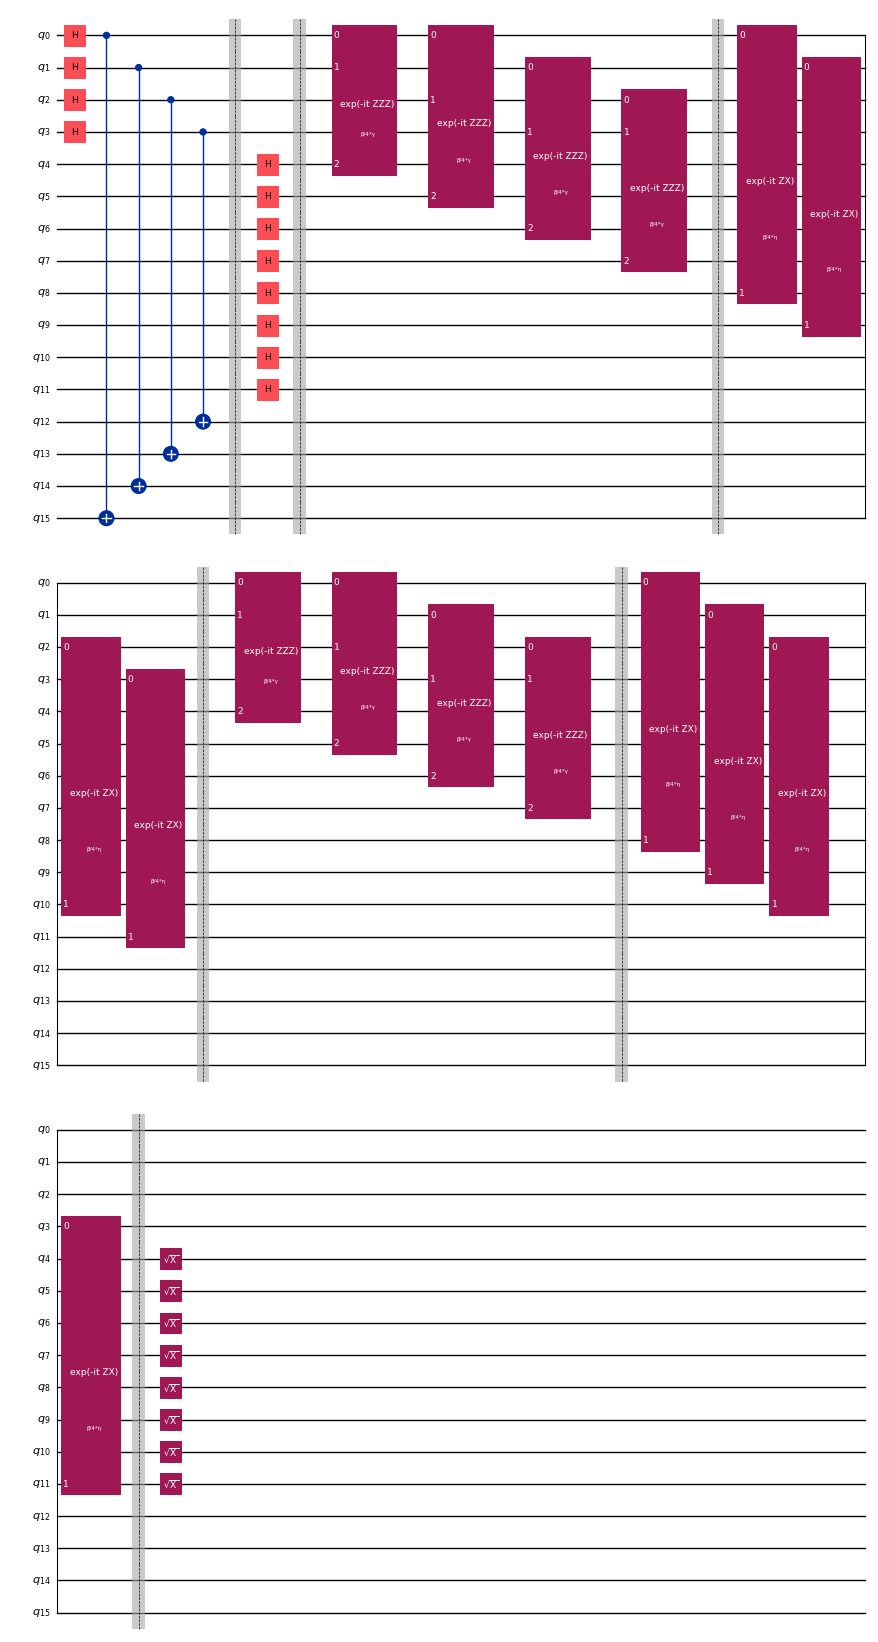

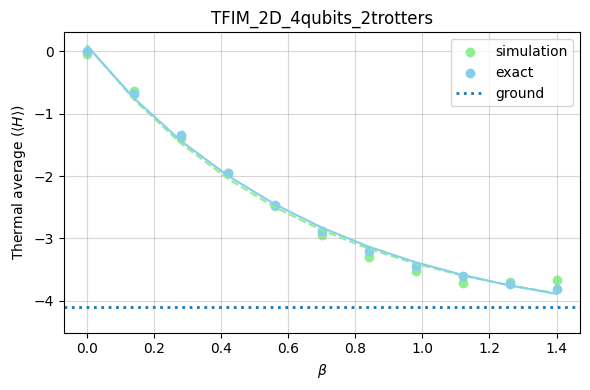

In [5]:
if __name__ == "__main__":
    """
    model: "tfim" or "xy"

    dimension: 1 for ID chain or 2 for 2D square lattice
    
    trotter_steps: recommended = 2 trotter_steps
    """
    
    output = run_model_experiment(model="tfim", dimension=2, num_qubits=4, trotter_steps=2)